# Pycox - CoxPH Model
- Network : 3 Hidden Layers, Linear with ReLU functions
- Input Variables : G1 ~ G300, Var1 ~ Var10, Treatment
- Output Variables : time, event
- Scaler : MinMaxScaler -> Var1 ~ Var10



In [ ]:
pip install pycox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper
import pandas as pd

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

- all-in-one.csv 파일은 유전자 변이 유무, 임상 변수, 생존 기간, 사망 여부, 치료 유무가 열로 존재하는 파일
- test-data-treat-and-untreat.csv 파일은 all-in-one의 열은 같은 602개의 데이터.
  - (0번째 행) : 유전자 변이 모두 0, 치료 0
  - (1번째 행) : 유전자 변이 모두 0, 치료 1
  - (2~301번째 행) : 유전자 변이 n-1에만 1, 치료 0
  - (302~601번재 행) : 유전자 변이 n-301에만 1, 치료 1
- pandas 라이브러리에 있는 csv 파일을 DataFrame으로 바꾸어주는 read_csv 함수를 이용하여 파일을 읽어 들임.
- DataFrame은 표를 나타내는 데이터 타입임.

In [ ]:
dataset = pd.read_csv('/content/all-in-one.csv')
dataset_for_hr = pd.read_csv('/content/test-data-treat-and-untreat.csv')

- 위에서 읽어들인 dataset 중에서 20%는 검증(_val -> validation)을 위해 sampling 한다.
- 남은 80%의 데이터에서도 20%는 테스트(_test)를 위해 sampling 한다.

In [ ]:
dataset_val = dataset.sample(frac=0.2)
dataset_train = dataset.drop(dataset_val.index)
dataset_test = dataset_train.sample(frac=0.2)
dataset_train = dataset_train.drop(dataset_test.index)

- columns_standardize : 임상변수 - 0~9사이의 값을 표준화
- columns_leave : 유전자 변이 유무 + 치료 유무 - 0과 1로 표현돼 있기 때문에 표준화 필요 없음.
- DataFrameMapper는 pandas DataFrame에서 원하는 열을 뽑아서 리스트로 만들어줌.
- 리스트로 만들때 StandardScaler()가 포함된 열은 표준화를 시킨 뒤, 그리고 None이면 갖고 있는 값을 그대로 넣음.

In [ ]:
columns_standardize = ['Var' + str(i) for i in range(1,11)]
columns_leave = ['G' + str(i) for i in range(1,301)]
columns_leave += ['Treatment']

# standardize = [([col], StandardScaler()) for col in columns_standardize]
standardize = [([col], MinMaxScaler()) for col in columns_standardize]

leave = [(col, None) for col in columns_leave]

x_mapper = DataFrameMapper(leave + standardize)

- 위에서 만든 DataFrameMapper로 DataFrame 중 x(입력) 데이터를 모델이 학습할 수 있게끔 리스트 형식으로 바꾸어 준다.



In [ ]:
x_train = x_mapper.fit_transform(dataset_train).astype('float32')
x_val = x_mapper.transform(dataset_val).astype('float32')
x_for_hr = x_mapper.transform(dataset_for_hr).astype('float32')

- DataFrame (표)에서 Y(출력)데이터인 time(생존기간)과 event(사망여부)를 뽑아 출력 데이터를 추린다.
- 검증(Validation)을 위한 입력-출력 세트 val을 만든다.

In [ ]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_train = get_target(dataset_train)
y_val = get_target(dataset_val)

durations_test, events_test = get_target(dataset_test)
val = x_val, y_val

- in_features : 입력데이터의 개수 (x_train.shape : 311 = 300(유전자) + 10(임상변수) + 1(치료유무))
- num_nodes : 우리가 사용하는 torch에서는 필요없음. (직접 숫자를 쓰기 때문에)
- out_features : 출력노드의 개수
- dropout : 제거하는 노드 비율 (?) (정확하지 않음 확인 필요)

- net : 우리가 설정할 네트워크 (현재는 hidden layer가 3개)

In [ ]:
in_features = x_train.shape[1]
# num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    
    torch.nn.Linear(32, out_features)
)

- CoxPH 모델 생성, net은 위에서 설계한 네트워크로, optimizer은 Adam 기법으로 (!= SGD)

In [ ]:
model = CoxPH(net, tt.optim.Adam)

- batch_size : 한 번의 학습에서 이용할 데이터 개수가 256
- lrfinder : 이 모델에서 적절한 학습률을 찾아주는 함수
- lrfinder.plot()을 하면 그래프를 그려줌.

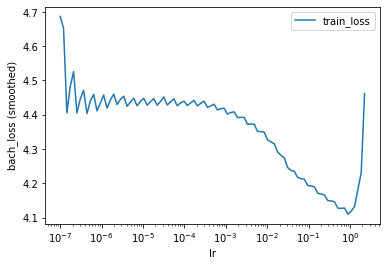

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

-lrfinder.get_best_lr() : lrfinder가 추천하는 학습률 return

In [ ]:
lrfinder.get_best_lr()

0.08902150854450441

- 위에서 얻은 학습률로 optimizer을 설정함

In [ ]:
model.optimizer.set_lr(lrfinder.get_best_lr())

- 512번 학습
- EarlyStopping() 함수는 학습에 진전이 없을 때 학습을 멈추게 하는 함수
- verbose는 뭔지 아직 모르겠음.

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

- 모델을 학습시키면서 log를 기록

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.6467,	val_loss: 4.2605
1:	[0s / 0s],		train_loss: 4.3845,	val_loss: 4.3460
2:	[0s / 0s],		train_loss: 4.2895,	val_loss: 4.3773
3:	[0s / 0s],		train_loss: 4.2146,	val_loss: 4.4627
4:	[0s / 0s],		train_loss: 4.1248,	val_loss: 4.5476
5:	[0s / 0s],		train_loss: 4.0431,	val_loss: 4.5937
6:	[0s / 0s],		train_loss: 4.0114,	val_loss: 4.4565
7:	[0s / 0s],		train_loss: 3.8862,	val_loss: 4.4271
8:	[0s / 0s],		train_loss: 3.8227,	val_loss: 4.5942
9:	[0s / 0s],		train_loss: 3.7926,	val_loss: 4.7199
10:	[0s / 0s],		train_loss: 3.7075,	val_loss: 4.6105
CPU times: user 194 ms, sys: 4.75 ms, total: 198 ms
Wall time: 290 ms


- 찍힌 log를 그래프로 그림

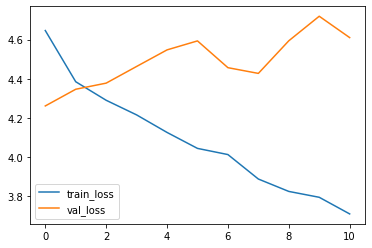

In [ ]:
_ = log.plot()

- 생존 함수를 그리기 위해서 baseline_hazard를 compute하는 이 함수를 호출해야 한다고 함.

In [ ]:
_ = model.compute_baseline_hazards()

- model.predict함수는 입력 데이터에 대한 log partial hazard를 구해줌.
- partial_hazard : predict 함수로 얻은 지수부분에 e를 취해 e^log_partial_hazard 값들을 리스트로 얻음.
- treat_hr : 300개의 유전자 변이에 대해서 치료가 0일때와 1일때 위험비를 계산해서 추가함.
- for문 설명 : 빈 리스트에 300개를 추가할건데 G1부터 G300까지 각각 치료했을 때/치료하지 않았을 때 위험비를 저장
- 치료 유무에 따른 위험비값을 기준으로 오름차순 정렬
- 위 값이 작을 수록 치료했을 때 위험률이 낮은 것이므로 유전자 앞의 10개 print
- 밑 두 알고리즘은 순서가 같게 나올 수 밖에 없음(밑의 알고리즘의 모든 항에서 분모 분자를 치료 여부에 따른 baseline hazard 값으로 나눠준것이기 때문)

In [42]:
base_untreat = partial_hazard[0]
base_treat = partial_hazard[1]

lee = []
for i in range(300):
  lee.append([(partial_hazard[i+302]/base_treat)/(partial_hazard[i+2]/base_untreat), 'G' + str(i+1)])
lee.sort()
lee[:10]

[[array([0.913125], dtype=float32), 'G13'],
 [array([0.91383135], dtype=float32), 'G223'],
 [array([0.91724545], dtype=float32), 'G298'],
 [array([0.91775125], dtype=float32), 'G8'],
 [array([0.9219296], dtype=float32), 'G300'],
 [array([0.9253484], dtype=float32), 'G233'],
 [array([0.9280697], dtype=float32), 'G111'],
 [array([0.92832047], dtype=float32), 'G83'],
 [array([0.92849237], dtype=float32), 'G162'],
 [array([0.93004274], dtype=float32), 'G190']]

In [41]:
log_partial_hazard = model.predict(x_for_hr)
partial_hazard = [np.exp(i) for i in log_partial_hazard]

treat_hr = []
# ratio with treated and untreated
for i in range(300):
  treat_hr.append([partial_hazard[i+302]/partial_hazard[i+2],'G' + str(i+1)])
treat_hr.sort()
treat_hr[:10]

[[array([1.0159743], dtype=float32), 'G13'],
 [array([1.0167601], dtype=float32), 'G223'],
 [array([1.0205588], dtype=float32), 'G298'],
 [array([1.0211215], dtype=float32), 'G8'],
 [array([1.0257705], dtype=float32), 'G300'],
 [array([1.0295744], dtype=float32), 'G233'],
 [array([1.0326023], dtype=float32), 'G111'],
 [array([1.0328814], dtype=float32), 'G83'],
 [array([1.0330725], dtype=float32), 'G162'],
 [array([1.0347975], dtype=float32), 'G190']]